In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import seaborn as sns

from tqdm import tqdm

import contractions
import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

from collections import defaultdict, Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fashaikh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fashaikh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Main Params for Matplotlib

In [2]:
plt.rcParams['figure.figsize'] = [18, 15]
plt.style.use('fivethirtyeight')

Main Params for Seaborn

In [3]:
sns.set(rc={'figure.figsize':(18, 15)})
sns.set_theme(style="darkgrid")

In [4]:
df_copy = pd.read_parquet(r"C:\Users\fashaikh\Desktop\Thesis_main\combined_emotion_sentiment.parquet")

In [5]:
df_copy.head()

,id,cleanedContent,label,category,emotion_label
0,1257990410028359681,Everyday that the killers of #AhmaudArbery rem...,negative,African American South,fear
1,1258706164054929408,It took 59 days for the @user to arrest #Grego...,negative,African American South,disgust
2,1258706164054929408,It took 59 days for the @user to arrest #Grego...,negative,African American South,disgust
3,1258706164054929408,It took 59 days for the @user to arrest #Grego...,negative,African American South,disgust
4,1258706164054929408,It took 59 days for the @user to arrest #Grego...,negative,African American South,disgust


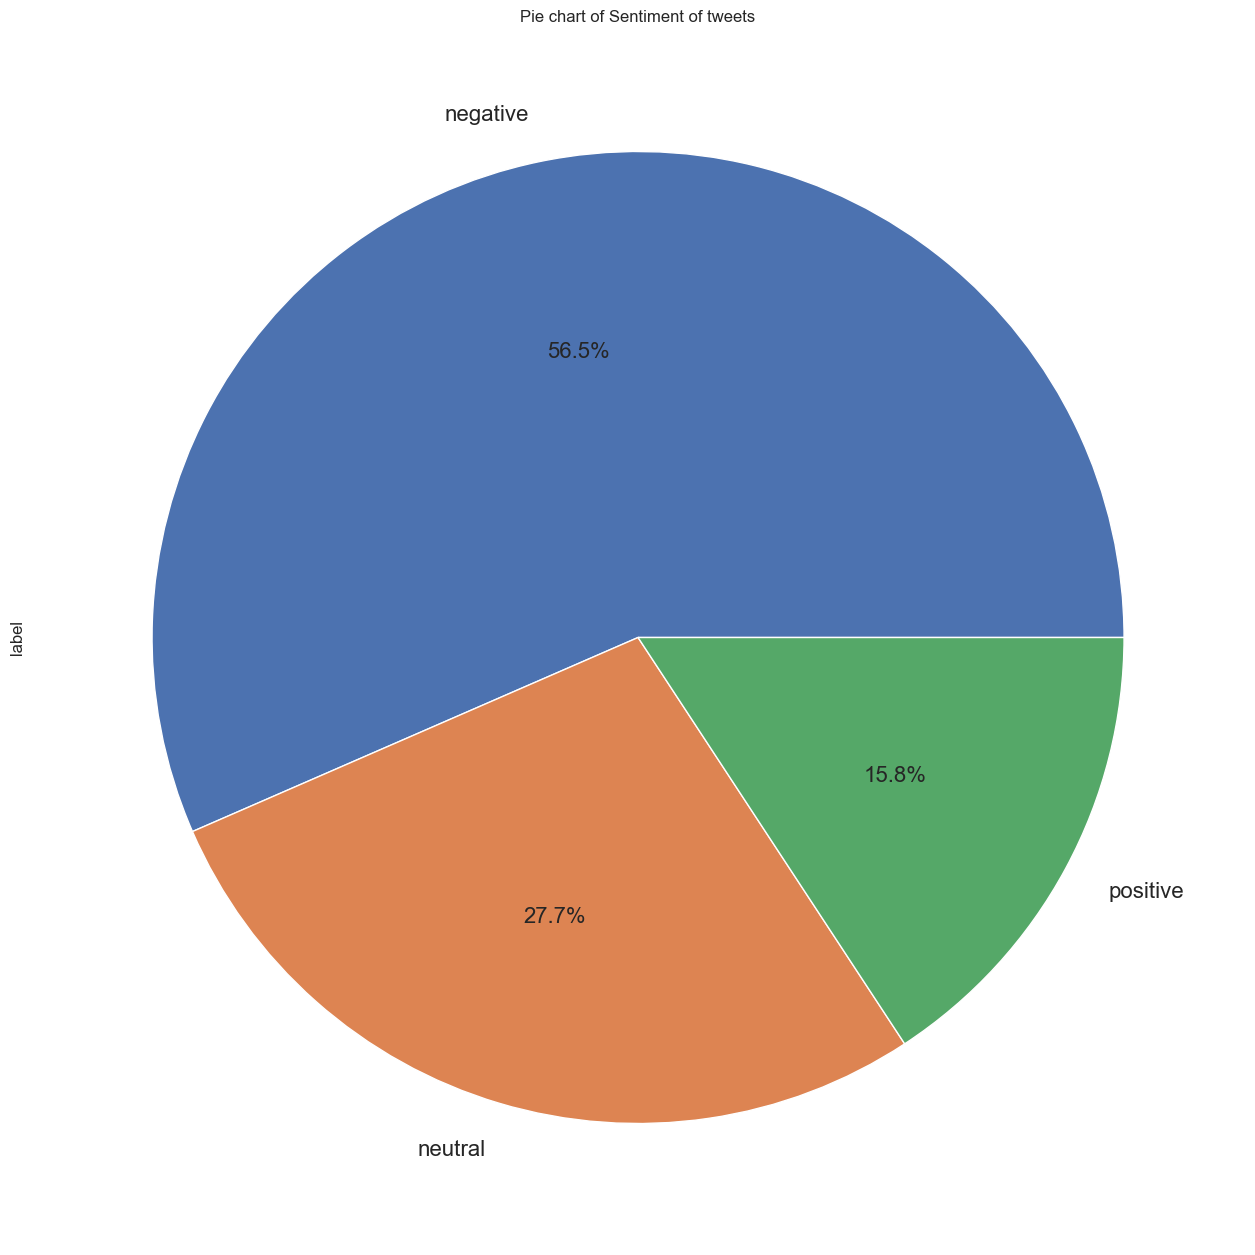

In [6]:
df_copy['label'].value_counts().plot(kind='pie',
                                         title='Pie chart of Sentiment of tweets', 
                                         autopct='%1.1f%%',
                                         shadow=False,
                                         legend = False, fontsize=16, figsize=(15,15))
plt.show()

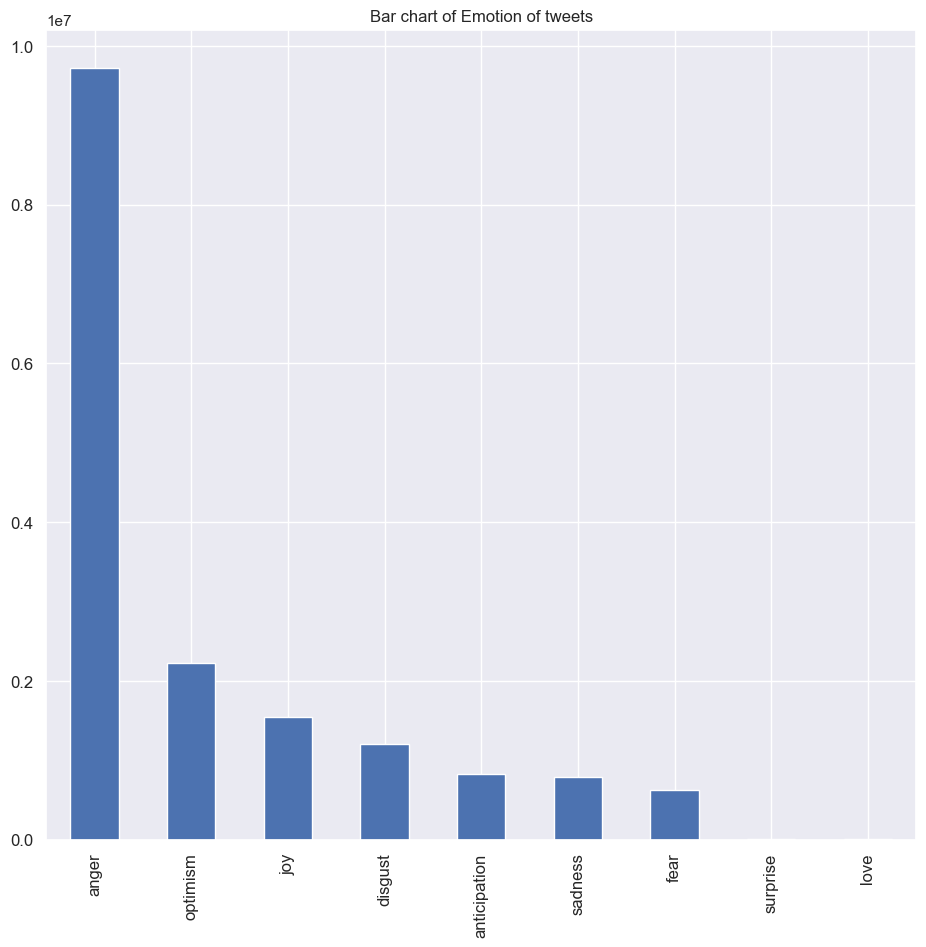

In [10]:
df_copy['emotion_label'].value_counts().plot(kind='bar',
                                         title='Bar chart of Emotion of tweets', 
                                         legend = False, fontsize=12, figsize=(10,10))
plt.show()

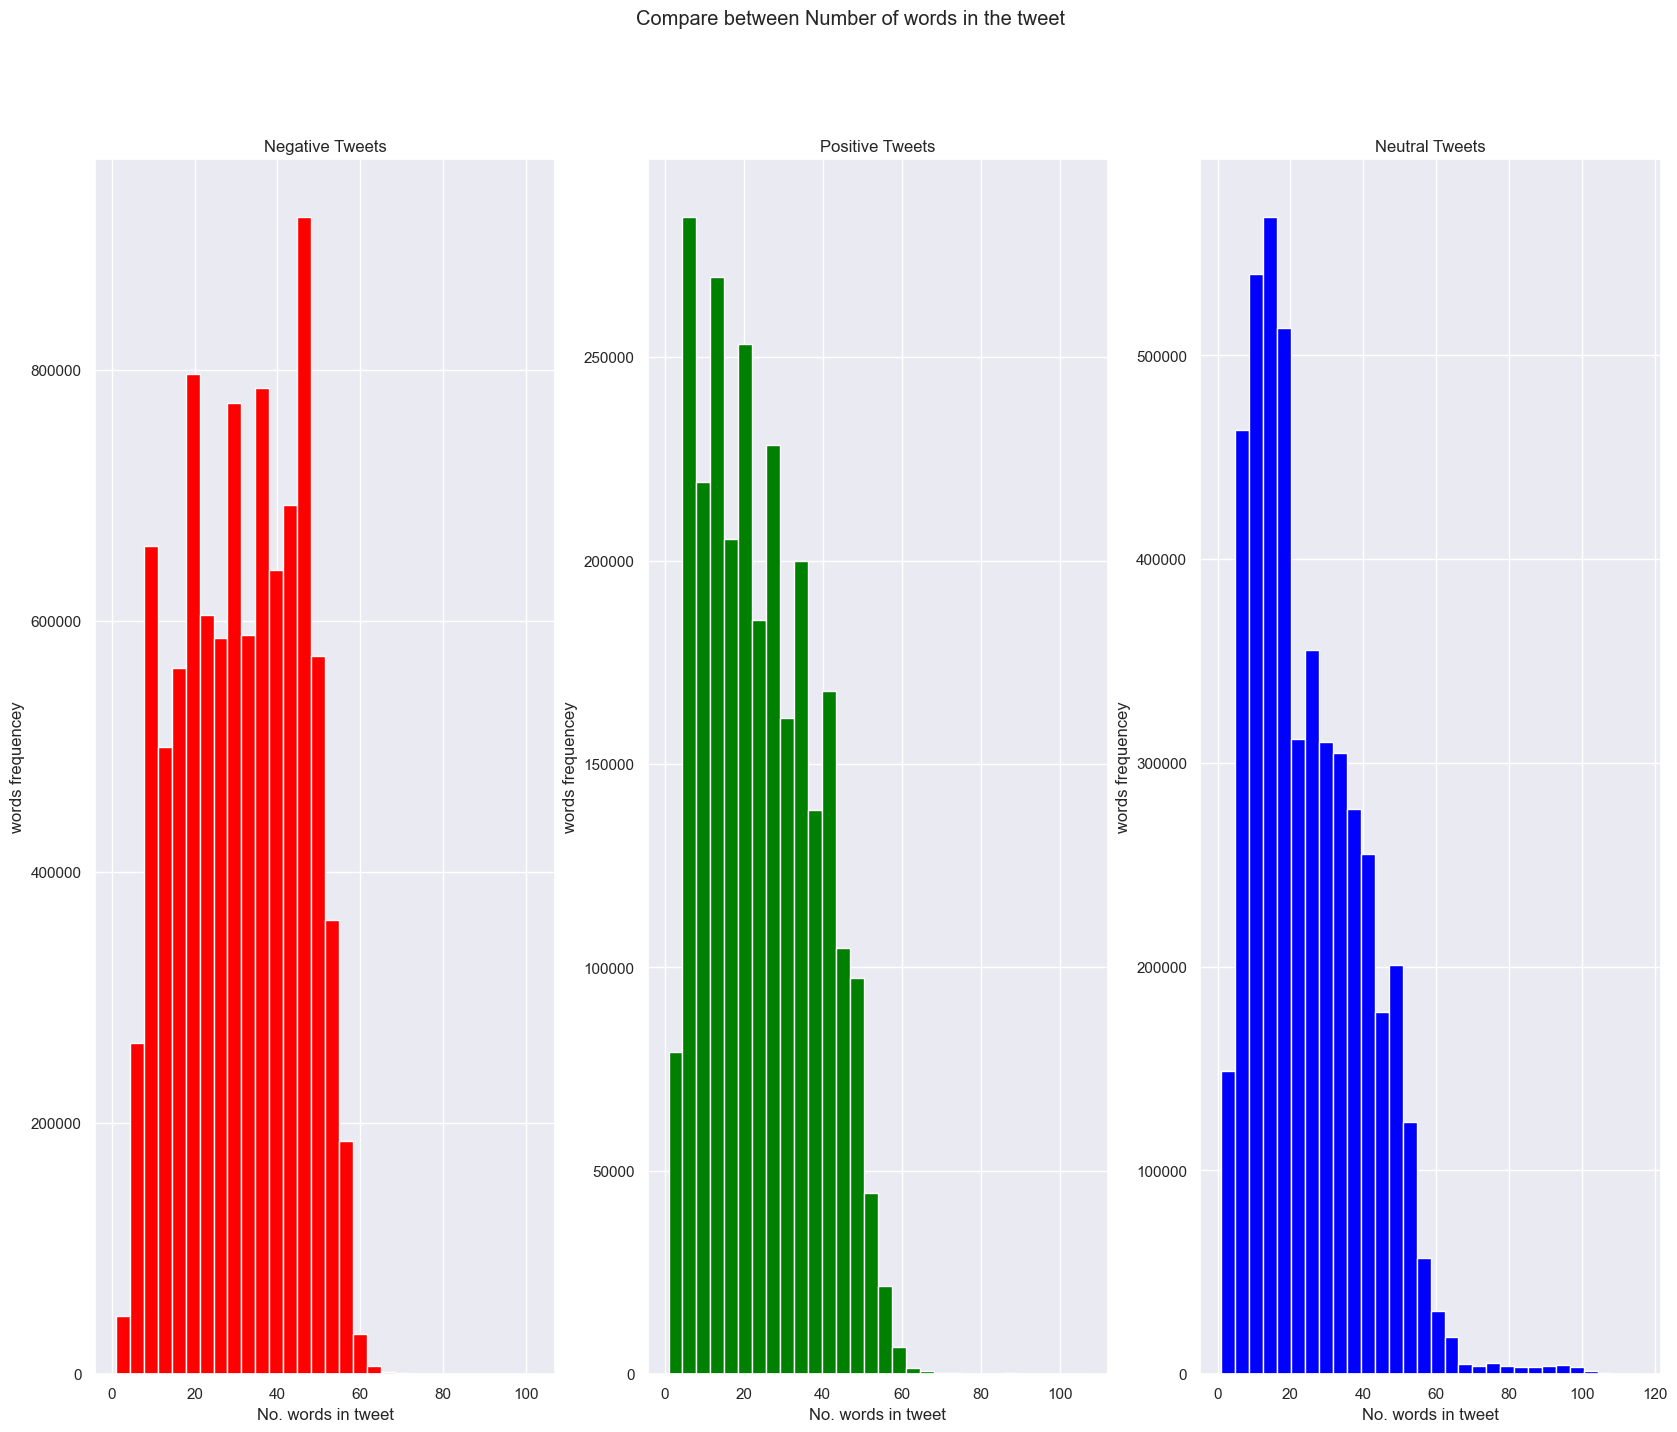

In [6]:
sns.set(style='darkgrid')
fig, axes = plt.subplots(1, 3)
fig.suptitle('Compare between Number of words in the tweet')

axes[0].hist(df_copy[df_copy['label'] == "negative"]['cleanedContent'].str.split().map(lambda word: len(word)),
             bins=30, color='red')
axes[0].set_ylabel('words frequencey')
axes[0].set_xlabel('No. words in tweet')
axes[0].set_title('Negative Tweets')


axes[1].hist(df_copy[df_copy['label'] == "positive"]['cleanedContent'].str.split().map(lambda word: len(word)),
             bins=30, color='green', label='Disaster')
axes[1].set_ylabel('words frequencey')
axes[1].set_xlabel('No. words in tweet')
axes[1].set_title('Positive Tweets')

axes[2].hist(df_copy[df_copy['label'] == "neutral"]['cleanedContent'].str.split().map(lambda word: len(word)),
             bins=30, color='blue', label='Disaster')
axes[2].set_ylabel('words frequencey')
axes[2].set_xlabel('No. words in tweet')
axes[2].set_title('Neutral Tweets')

plt.show()

### Clean Tweet

In [7]:
def clean_tweet(text):
    # Remove mentions
    text = re.sub(r"@user", "", text)

    # Remove URLs
    text = re.sub(r"http", "", text)

    # Remove extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()

    # Remove leading whitespaces
    text = re.sub(r"^\s+","",text)

    # Replace &amp; with and
    text = re.sub(r"&amp;","and",text)

    return text

In [8]:
df_copy['text'] = df_copy['cleanedContent'].apply(clean_tweet)

In [ ]:
def parse_hashtags(text):
    hashtag=re.compile(r'(\#)(\w+)(_)(\w+)', re.IGNORECASE)
    text = hashtag.sub(r'\2 \4',text)
    return text.replace('_', ' ')

In [7]:
df_copy['text'] = df_copy['text'].apply(lambda sentence: parse_hashtags(sentence))

In [9]:
def en_contractions(text):
    return ' '.join([contractions.fix(word) if word in contractions.contractions_dict else word for word in text.split()])

In [10]:
df_copy['text'] = df_copy['text'].apply(lambda sentence: en_contractions(sentence))

In [11]:
s_chars = '¥₽ÏïŰŬĎŸæ₿₪ÚŇÀèÅ”ĜåŽÖéříÿý€ŝĤ₹áŜŮÂ₴ûÌÇšŘúüëÓ₫ŠčÎŤÆÒœ₩öËäøÍťìĈôàĥÝ¢ç“žðÙÊĉŭÈŒÐÉÔĵùÁů„âÄűĴóêĝÞîØòď฿ČÜþňÛ'
PUNC = '.+@«#_\-!$%%^&*¬()£<>?/\\|}\]\[{;\,~:\"\''

In [12]:
def special_char(text):
    # first, let's remove any unicode strings
    text = text.encode('ascii', 'ignore').decode()
    # remove printable bachslashes
    text = re.sub(r'[\t\s\n\r\b\a]', ' ', text)
    # Special letters
    text = re.sub(r'[{}]'.format(s_chars), '', text)
    # Punctuation
    text = re.sub(r'[{}]'.format(PUNC), ' ', text)
    # space at the start or the end of the context
    text = re.sub(r'(^\s)|(\s$)', '', text)
    # Single character
    text = re.sub(r'(\s[^iIaA]\s)', ' ', text)
    return text

In [13]:
df_copy['text'] = df_copy['text'].apply(lambda sentence: special_char(sentence))

In [14]:
df_copy['text'] = df_copy['text'].str.replace('\d+', '', regex=True)

In [15]:
df_copy['text'] = df_copy['text'].str.replace("yr", 'year', regex=False)
df_copy['text'] = df_copy['text'].str.replace(r"\.|==|=|'|`|(PM)|(AM)|(UTC)", ' ', regex=True)
df_copy['text'] = df_copy['text'].str.replace("...", '', regex=False)
df_copy['text'] = df_copy['text'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
df_copy['text'] = df_copy['text'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
df_copy['text'] = df_copy['text'].str.replace(r'\s ', ' ', regex=True)
df_copy['text'] = df_copy['text'].str.replace(r'(^\s)|(\s$)', '', regex=True)

### Stopwords cleaning

In [16]:
SWs = stopwords.words('english')

In [17]:
df_copy['text'] = df_copy['text'].str.lower()

In [18]:
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in SWs])

In [19]:
df_copy['text_without_stopwords'] = df_copy['text'].apply(lambda sentence: remove_stopwords(sentence))

In [20]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'J': wordnet.ADJ, 'R': wordnet.ADJ}

In [21]:
def adjusted_lemmatizer(text):
    # Split the sentence into words and each word with its type
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [22]:
df_copy['text_lemmatized'] = df_copy['text_without_stopwords'].apply(lambda sentence: adjusted_lemmatizer(sentence))

In [31]:
df_copy['text_lemmatized'] = df_copy['text_lemmatized'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
df_copy['text_lemmatized'] = df_copy['text_lemmatized'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
df_copy['text_lemmatized'] = df_copy['text_lemmatized'].str.replace(r'\s ', ' ', regex=True)
df_copy['text_lemmatized'] = df_copy['text_lemmatized'].str.replace(r'(^\s)|(\s$)', '', regex=True)

In [32]:
len(df_copy['text_lemmatized'].loc[
    df_copy['text_lemmatized'].str.contains(r"(\s[^iIaA]\s)")])

0

In [19]:
df_copy.to_parquet(r"C:\Users\fashaikh\Desktop\Thesis_main\lemmatized.parquet")

In [3]:
df_copy = pd.read_parquet(r"C:\Users\fashaikh\Desktop\Thesis_main\lemmatized.parquet")

In [17]:
#drop rows that have length <50
# rows dropped: 4065509 
print(f"Before dropping rows: {len(df_copy)}")
df_copy = df_copy[df_copy['cleanedContent'].str.len() <= 280]
print(f"After dropping rows: {len(df_copy)}")

Before dropping rows: 14245313
After dropping rows: 12912184


In [20]:
def plot_words_freq(dataframe: pd.DataFrame,
                    column,
                    target_label, axes):
    words_dict = {'word': [], 'count': []}
    words_count = Counter(
        ' '.join(dataframe[[column,'label']]\
                 .loc[dataframe['label'] == target_label]\
                 [column]).split()).most_common(100)
    
    for word, count in words_count:
        words_dict['word'].append(word)
        words_dict['count'].append(count)
    
    sns.barplot(x=words_dict['count'][:20], y=words_dict['word'][:20], ax=axes)
    axes.set_yticks(range(20), words_dict['word'][:20], size=16)

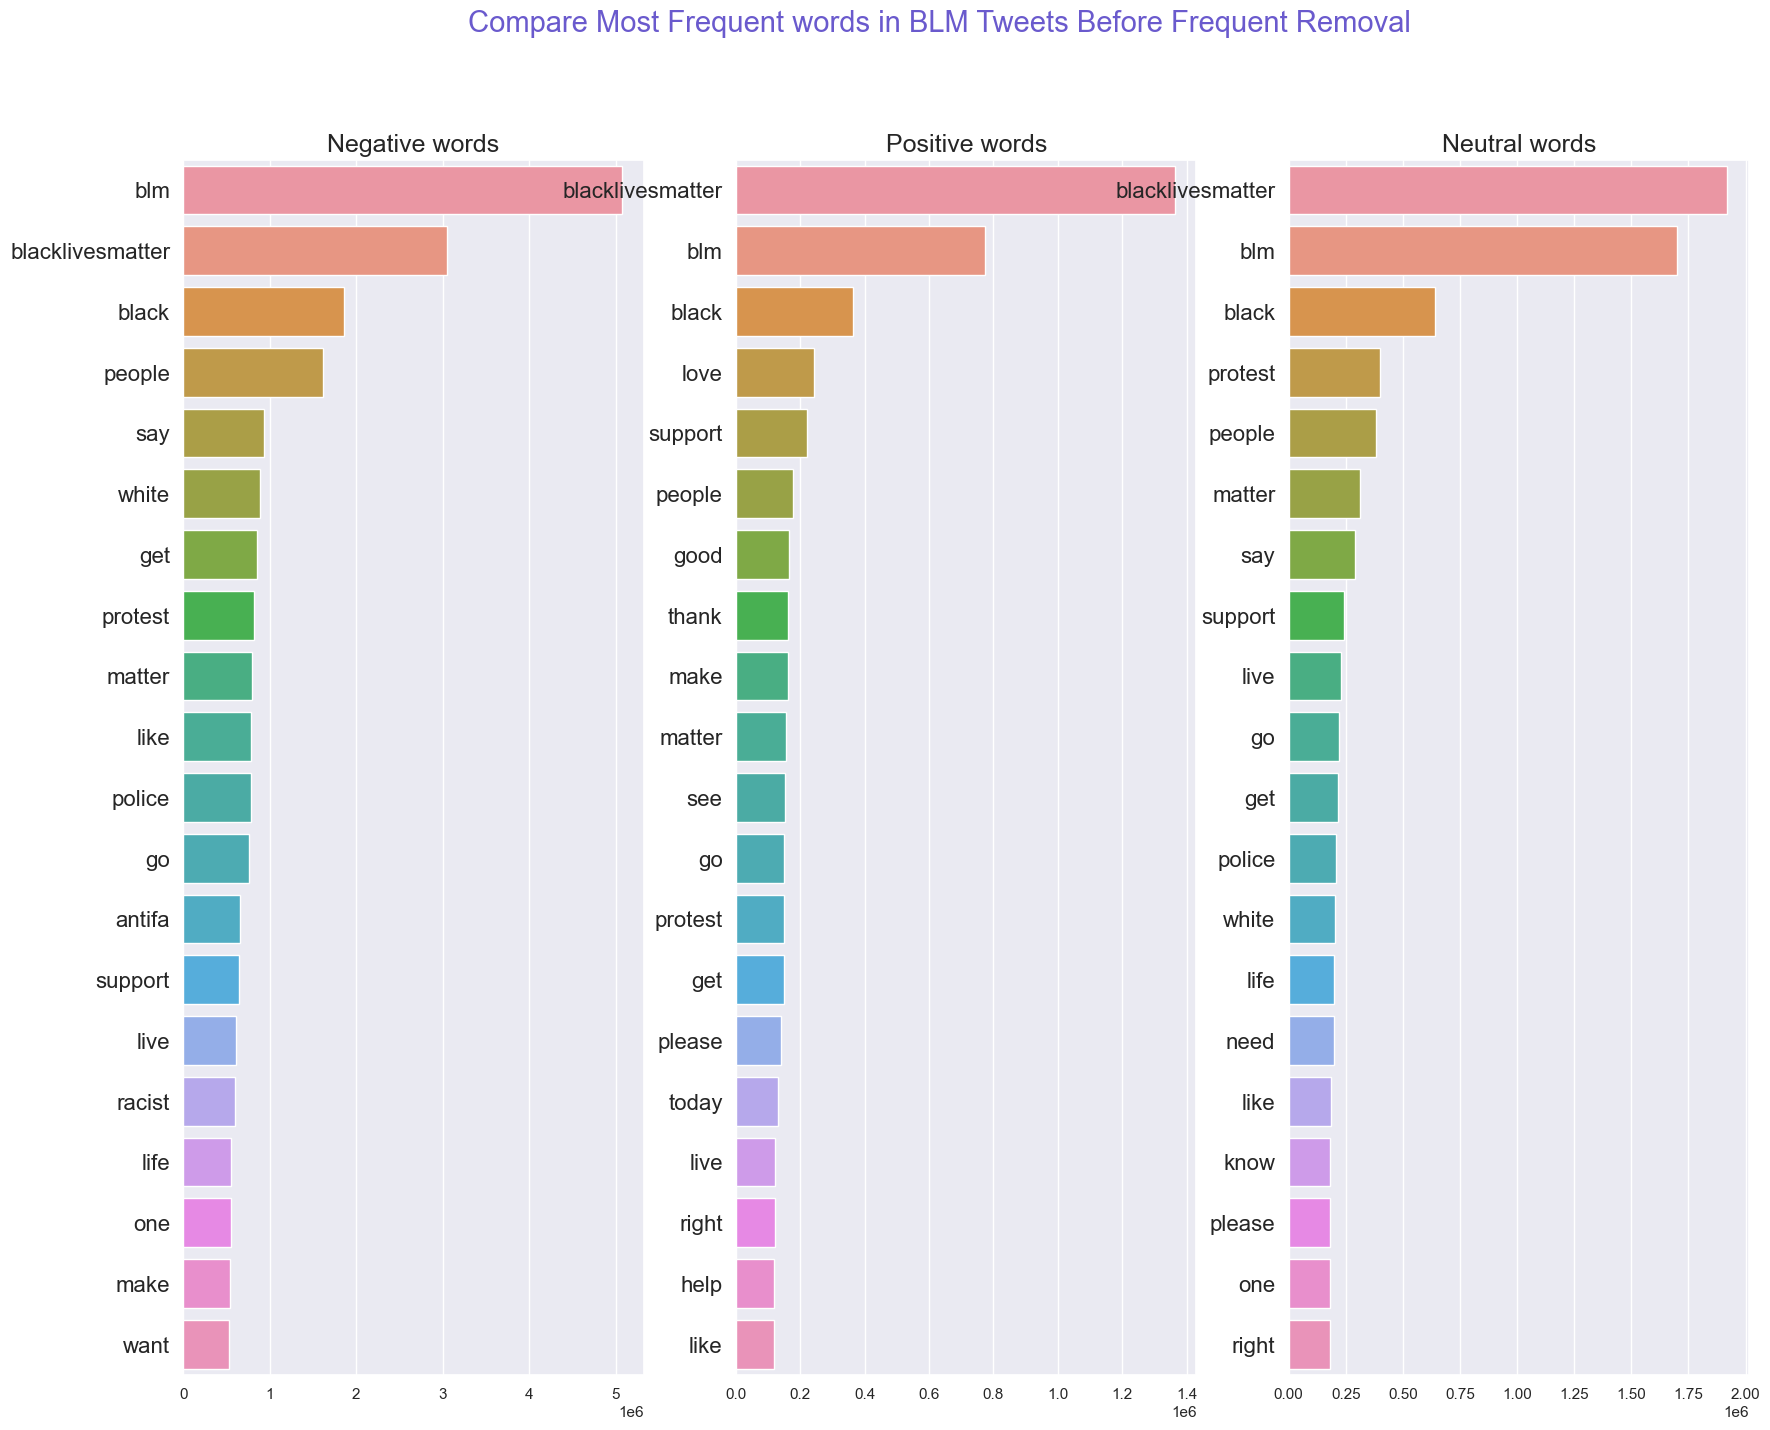

In [21]:
fig, axes = plt.subplots(1, 3)

fig.suptitle('Compare Most Frequent words in BLM Tweets Before Frequent Removal',
             size=21, color='SlateBlue')
axes[0].set_title('Negative words', size=18)
axes[1].set_title('Positive words', size=18)
axes[2].set_title('Neutral words', size=18)

plot_words_freq(df_copy, 'text_lemmatized', target_label="negative", axes=axes[0])
plot_words_freq(df_copy, 'text_lemmatized', target_label="positive", axes=axes[1])
plot_words_freq(df_copy, 'text_lemmatized', target_label="neutral", axes=axes[2])
plt.show()

In [22]:
NEGATIVE_WORDS = ['white', 'protest', 'police', 'antifa', 'kill', 'racist', 'trump']
POSITIVE_WORDS = ['love', 'thank', 'good', 'please', 'today', 'right', 'help']

In [23]:
def words_counter_removal(dataframe: pd.DataFrame,
                          column,
                          frequency,
                          ascending: False):
    """
    | Select the topest/lowest frequent words to in a set.
    Args:
        dataframe[pd.DataFrame]: dataframe you're going to select the frequent words from.
        column[Text]: column you're going to select the frequent words from.
        frequency[int]: the number of words you're going to select from the list of tuples.
        ascending[Optional[bool]]: whether ascending | descending. (default: False)
    Returns:
        Set[Text]
    """
    counter = Counter()
    for tweet in dataframe[column].values:
        for word in tweet.split():
            counter[word] += 1
    
    # Words should not be detected
    for word in NEGATIVE_WORDS + POSITIVE_WORDS:
        counter.pop(word)
    
    if not ascending:
        return set([word for (word, counts) in counter.most_common(frequency)])
    else:
        return set([word for (word, counts) in counter.most_common()[:-frequency-1:-1]])

In [24]:
FREQ_WORDS = words_counter_removal(df_copy, 'text_lemmatized', 20, False)

In [25]:
def remove_freqwords(text,
                     freq_words):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in freq_words])

In [26]:
df_copy['text_without_stopwords_freq'] = df_copy['text_lemmatized'].apply(lambda text: remove_freqwords(text, FREQ_WORDS))

In [27]:
df_copy.head()

,cleanedContent,label,emotion_label,category,text,text_without_stopwords,text_lemmatized,text_without_stopwords_freq
0,Everyday that the killers of #AhmaudArbery rem...,negative,fear,African American South,everyday that the killers of ahmaudarbery rema...,everyday killers ahmaudarbery remain free anot...,everyday killer ahmaudarbery remain free anoth...,everyday killer ahmaudarbery remain free anoth...
1,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,take day arrest gregorymcmichael travismcmicha...
2,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,take day arrest gregorymcmichael travismcmicha...
3,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,take day arrest gregorymcmichael travismcmicha...
4,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,take day arrest gregorymcmichael travismcmicha...


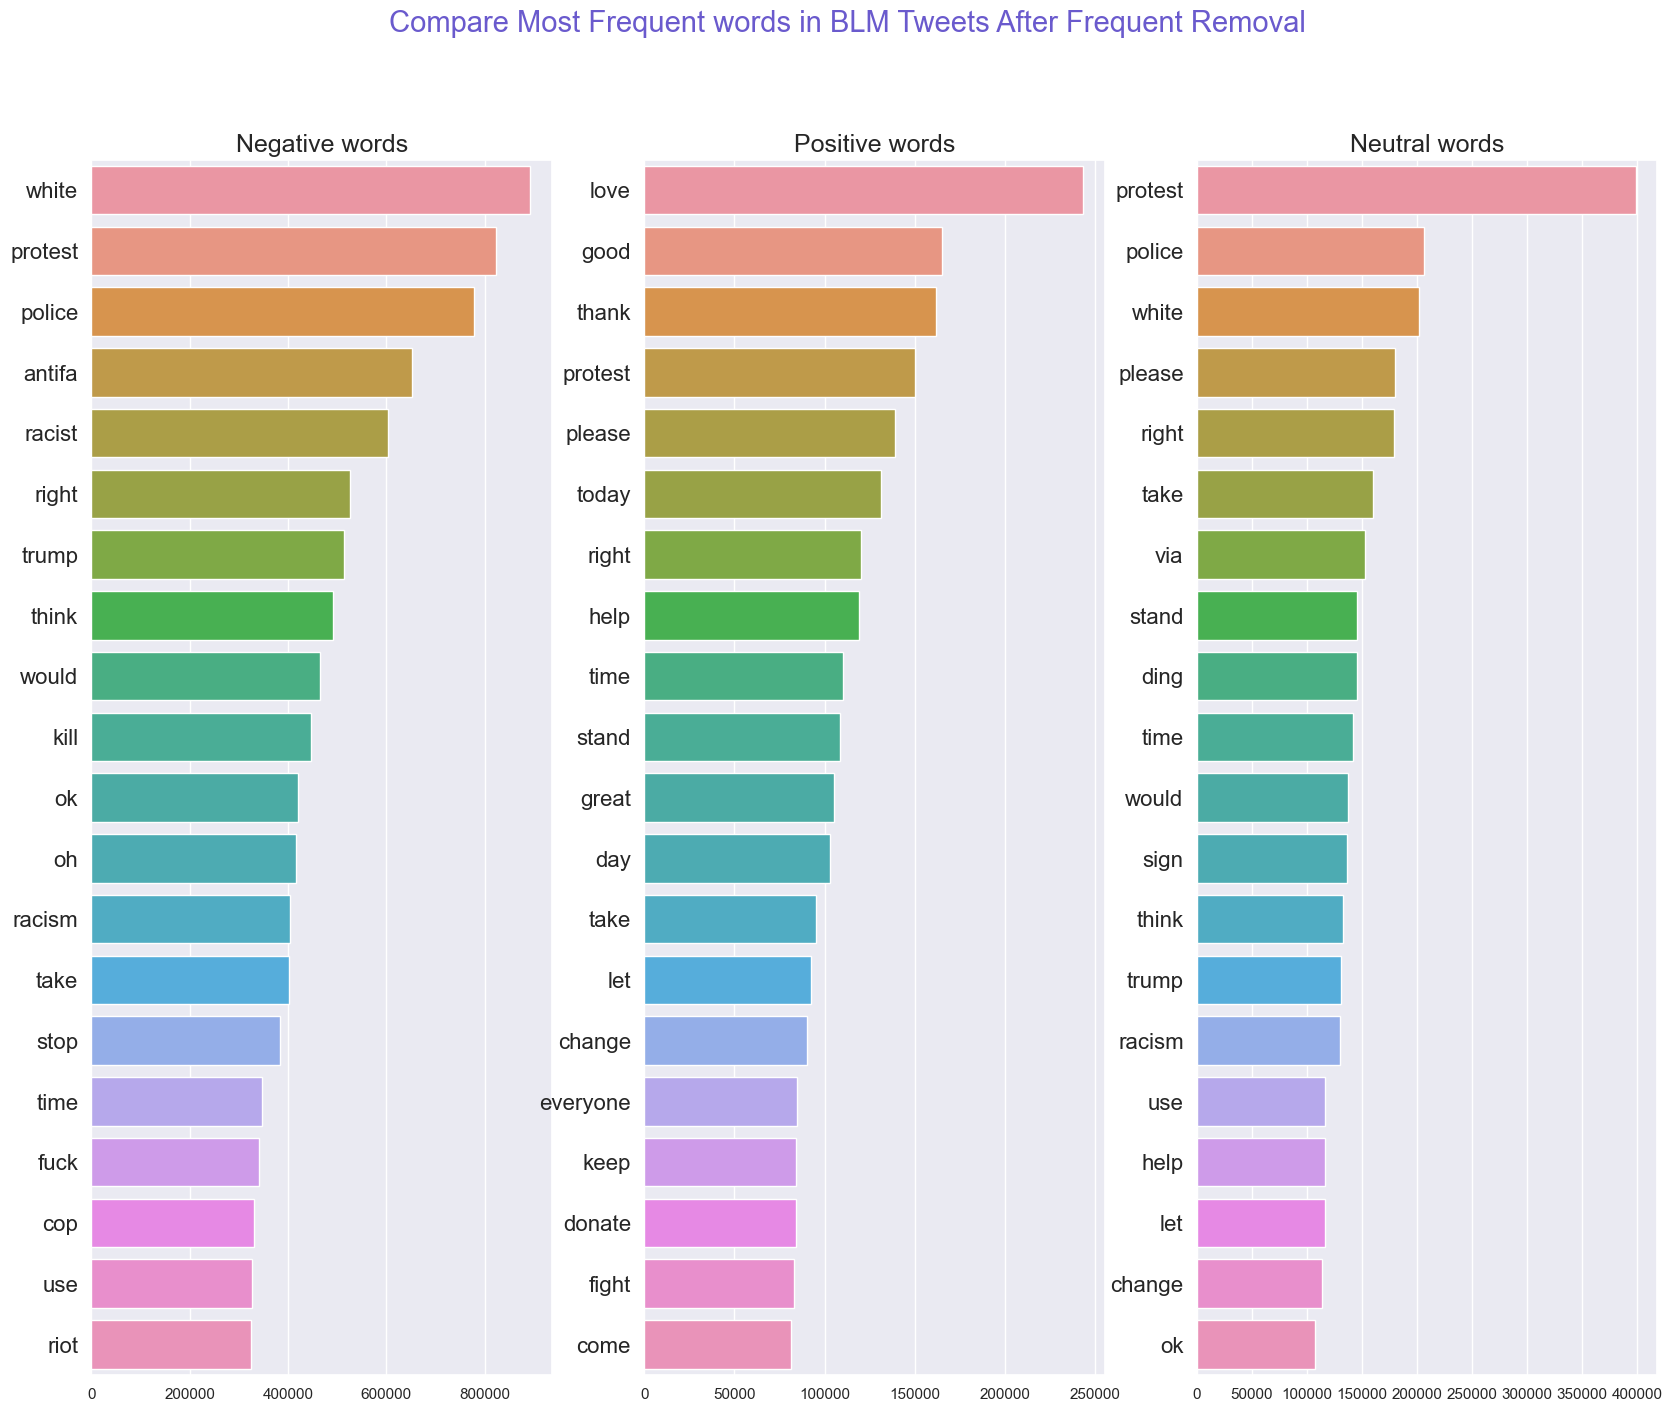

In [28]:
fig, axes = plt.subplots(1, 3)

fig.suptitle('Compare Most Frequent words in BLM Tweets After Frequent Removal',
             size=21, color='SlateBlue')
axes[0].set_title('Negative words', size=18)
axes[1].set_title('Positive words', size=18)
axes[2].set_title('Neutral words', size=18)

plot_words_freq(df_copy, 'text_without_stopwords_freq', target_label="negative", axes=axes[0])
plot_words_freq(df_copy, 'text_without_stopwords_freq', target_label="positive", axes=axes[1])
plot_words_freq(df_copy, 'text_without_stopwords_freq', target_label="neutral", axes=axes[2])
plt.show()

In [29]:
# Define the N-grams function
def gen_ngrams_fn(text, n_grams=2):
    # Split all the words and insert them into list in sequence;
    ## First, ensure that the word is not a `space`.
    ## Second, the word you're going to insert not inside the stopwords.
    word_list = [word for word in text.lower().split() 
                 if word != ' ']
    
    # capture N-sequence of words togther
    ngrams = zip(*[word_list[i:] for i in range(n_grams)])
    
    # Convert the context from list to str
    return [' '.join(ngram) for ngram in ngrams]

In [30]:
def ngrams_fn(dataframe,
              target_label,
              n_grams=2,
              sort=True):
    
    n_grams_dict = defaultdict(int)
    
    for tweet in dataframe[['text_without_stopwords_freq', 'label']]\
                     .loc[dataframe['label'] == target_label]['text_without_stopwords_freq']:
        for context in gen_ngrams_fn(tweet, n_grams):
            # Apply N-grams probability of the occurrence of certain N-words in certain Sequence
            # in form of most occurrence
            n_grams_dict[context] +=1
    
    # Create dataframe with number of occurrences is the id we sort the data with.
    n_grams_dataframe = pd.DataFrame(n_grams_dict.items())
    n_grams_dataframe.columns = ['N-grams', 'occurs']

    if sort:
        n_grams_dataframe.sort_values(by='occurs', ascending=False, inplace=True)
    
    return n_grams_dataframe


def plot_ngrams(dataframe,
                axes,
                number_of_samples=20) -> None:
    # Plot the dataset
    sns.barplot(x=dataframe.iloc[:,1][:number_of_samples],
                y=dataframe.iloc[:,0][:number_of_samples], ax=axes)
    axes.set_yticks(range(number_of_samples),
                    dataframe.iloc[:,0][:number_of_samples], size=14)

In [52]:
neg_bigrams = ngrams_fn(df_copy, target_label='negative')

In [53]:
neg_bigrams.to_parquet(r"C:\Users\fashaikh\Desktop\Thesis_main\negative_bigrams.parquet")

In [54]:
pos_bigrams = ngrams_fn(df_copy, target_label='positive')

In [55]:
pos_bigrams.to_parquet(r"C:\Users\fashaikh\Desktop\Thesis_main\positive_bigrams.parquet")

In [56]:
neu_bigrams = ngrams_fn(df_copy, target_label='neutral')

In [57]:
neu_bigrams.to_parquet(r"C:\Users\fashaikh\Desktop\Thesis_main\neutral_bigrams.parquet")

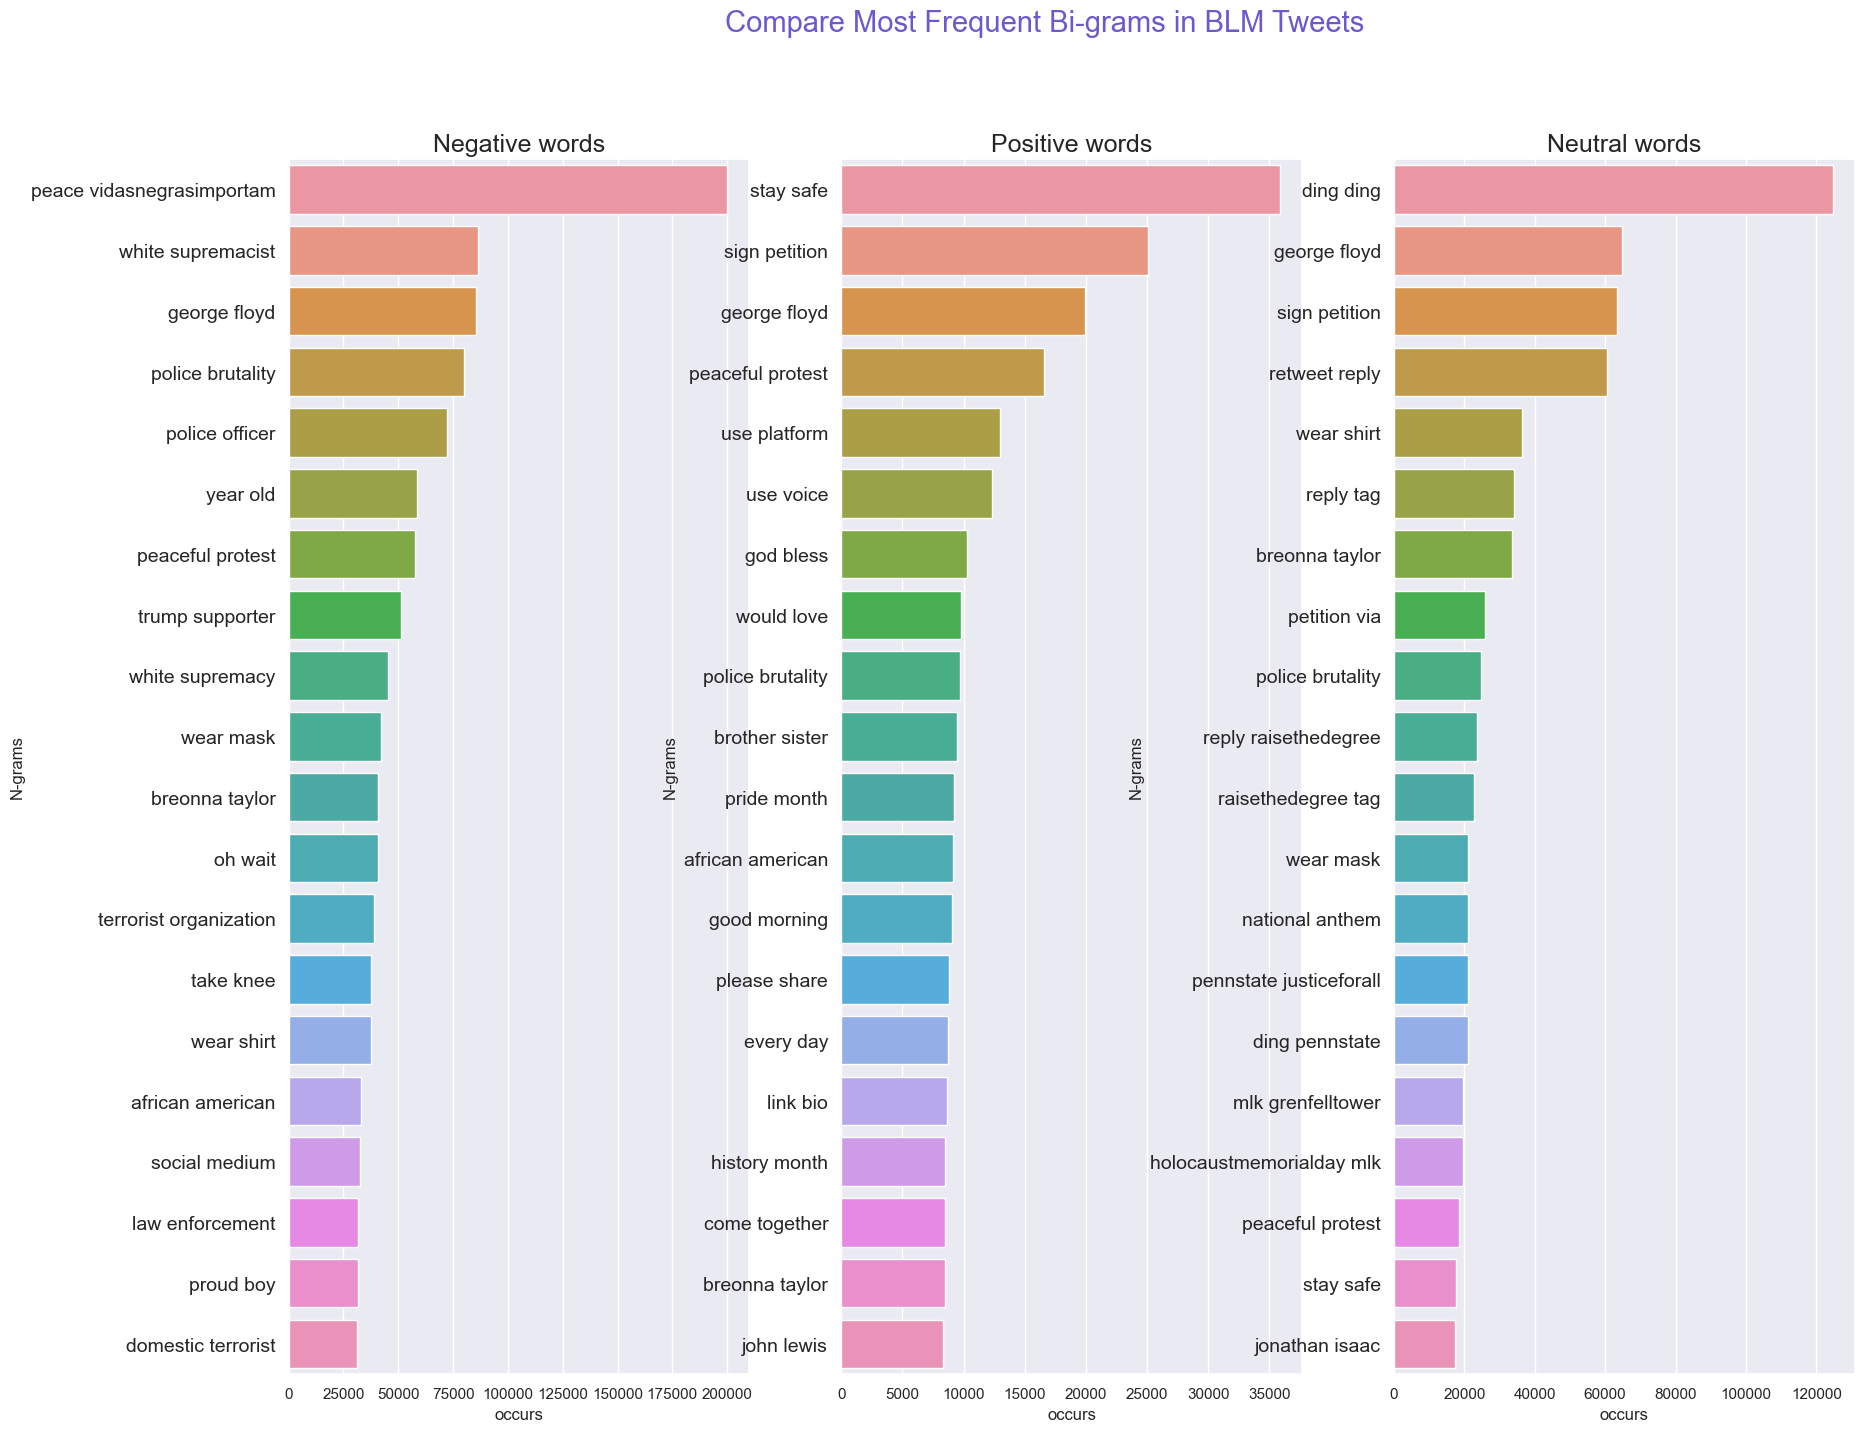

In [31]:
fig, axes = plt.subplots(1, 3)

fig.suptitle('Compare Most Frequent Bi-grams in BLM Tweets',
             size=21, color='SlateBlue')
axes[0].set_title('Negative words', size=18)
axes[1].set_title('Positive words', size=18)
axes[2].set_title('Neutral words', size=18)

plot_ngrams(ngrams_fn(df_copy, target_label='negative'), axes=axes[0])
plot_ngrams(ngrams_fn(df_copy, target_label='positive'), axes=axes[1])
plot_ngrams(ngrams_fn(df_copy, target_label='neutral'), axes=axes[2])
plt.show()

In [42]:
to_drop = [
    "ding ding",
    "retweet reply",
    "wear shirt"
    "reply tag",
    "ding pennstate",
    "oh wait",
    "oh yeah",
    "pride month",
    "link bio",
    "well ask",
    "sound like",
    "act like",
    "fbr",
    "tweetuk",
    "gt gt gt",
    "asian vet lgbtq",
    "voteblue follow follow",
    "indie dems"
]
df_copy = df_copy[
    ~df_copy["text_without_stopwords_freq"].str.contains("|".join(to_drop))
]

In [43]:
len(df_copy)

12665047

In [49]:
df_copy['hashtag_count'] = df_copy['cleanedContent'].str.count('#')

In [62]:
df_copy['hashtag_count'].value_counts()

0     4170985
1     2849399
2     1655290
3      947886
4      515593
5      272177
6      140027
7       76239
8       36576
9       15457
10       6129
11       2323
12        601
13        357
14         54
15         53
16         46
17          6
18          3
19          1
Name: hashtag_count, dtype: int64

In [51]:
df_copy['sentence_length'] = df_copy['text'].str.len()

In [54]:
df_copy['hashtag_length'] = df_copy['cleanedContent'].str.findall(r'#\w+').str.join(' ').str.len()

In [55]:
df_copy['hashtag_length'].value_counts()

0      4177388
17     1977528
4       724785
59      244536
40      143825
        ...   
277          2
282          2
280          2
278          2
274          1
Name: hashtag_length, Length: 280, dtype: int64

In [56]:
df_copy['ratio'] = df_copy['hashtag_length']/df_copy['sentence_length']

In [63]:
df_copy = df_copy[df_copy['hashtag_count'] <= 10]

In [64]:
df_copy

,cleanedContent,label,emotion_label,category,text,text_without_stopwords,text_lemmatized,text_without_stopwords_freq,hashtag_count,sentence_length,hashtag_length,ratio
0,Everyday that the killers of #AhmaudArbery rem...,negative,fear,African American South,everyday that the killers of ahmaudarbery rema...,everyday killers ahmaudarbery remain free anot...,everyday killer ahmaudarbery remain free anoth...,everyday killer ahmaudarbery remain free anoth...,2,216,31,0.143519
1,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,take day arrest gregorymcmichael travismcmicha...,5,185,77,0.416216
2,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,take day arrest gregorymcmichael travismcmicha...,5,185,77,0.416216
3,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,take day arrest gregorymcmichael travismcmicha...,5,185,77,0.416216
4,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,take day arrest gregorymcmichael travismcmicha...,5,185,77,0.416216
...,...,...,...,...,...,...,...,...,...,...,...,...
164840,@user Oh give your head a shake. Don’t forget ...,negative,anger,Working Class Country,oh give your head a shake dont forget it was b...,oh give head shake dont forget blm antifa star...,oh give head shake dont forget blm antifa star...,oh give head shake dont forget antifa start vi...,0,196,0,0.000000
164841,@user Just a guy with a full face mask and an ...,neutral,disgust,Working Class Country,just a guy with a full face mask and an ar sta...,guy full face mask ar standing new blm mural d...,guy full face mask ar stand new blm mural down...,guy full face mask ar stand new mural downtown...,0,123,0,0.000000
164842,@user Oh do go back and watch videos of those ...,neutral,anger,Working Class Country,oh do go back and watch videos of those in the...,oh go back watch videos democrat party see ver...,oh go back watch video democrat party see verb...,oh back watch video democrat party verbally ba...,0,187,0,0.000000
164843,"@user Oh, that makes sense. Just vote for the ...",negative,anger,Working Class Country,oh that makes sense just vote for the one who ...,oh makes sense vote one emboldens antifa idiot...,oh make sense vote one embolden antifa idiot b...,oh sense vote embolden antifa idiot marxist bu...,0,123,0,0.000000


In [65]:
df_copy.drop(columns=['hashtag_count', 'sentence_length', 'hashtag_length', 'ratio'], inplace=True)

In [ ]:
df_copy.to_parquet("topic_modeling.parquet")

In [37]:
ngrams_fn(df_copy, target_label='negative', n_grams=2).reset_index(drop=True)\
.head(50).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,peace vidasnegrasimportam,200048
1,white supremacist,86215
2,george floyd,85254
3,police brutality,79938
4,police officer,72281
5,year old,58529
6,peaceful protest,57426
7,trump supporter,51235
8,white supremacy,45094
9,wear mask,42062


In [39]:
ngrams_fn(df_copy, target_label='positive', n_grams=2).reset_index(drop=True)\
.head(50).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,stay safe,35662
1,sign petition,25048
2,george floyd,19949
3,peaceful protest,16555
4,use platform,12962
5,use voice,12344
6,god bless,10250
7,police brutality,9649
8,would love,9490
9,brother sister,9469


In [41]:
ngrams_fn(df_copy, target_label='neutral', n_grams=2).reset_index(drop=True)\
.head(50).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,george floyd,64577
1,sign petition,62714
2,wear shirt,36264
3,breonna taylor,33405
4,petition via,25866
5,police brutality,24634
6,national anthem,21028
7,wear mask,20994
8,mlk grenfelltower,19512
9,holocaustmemorialday mlk,19456


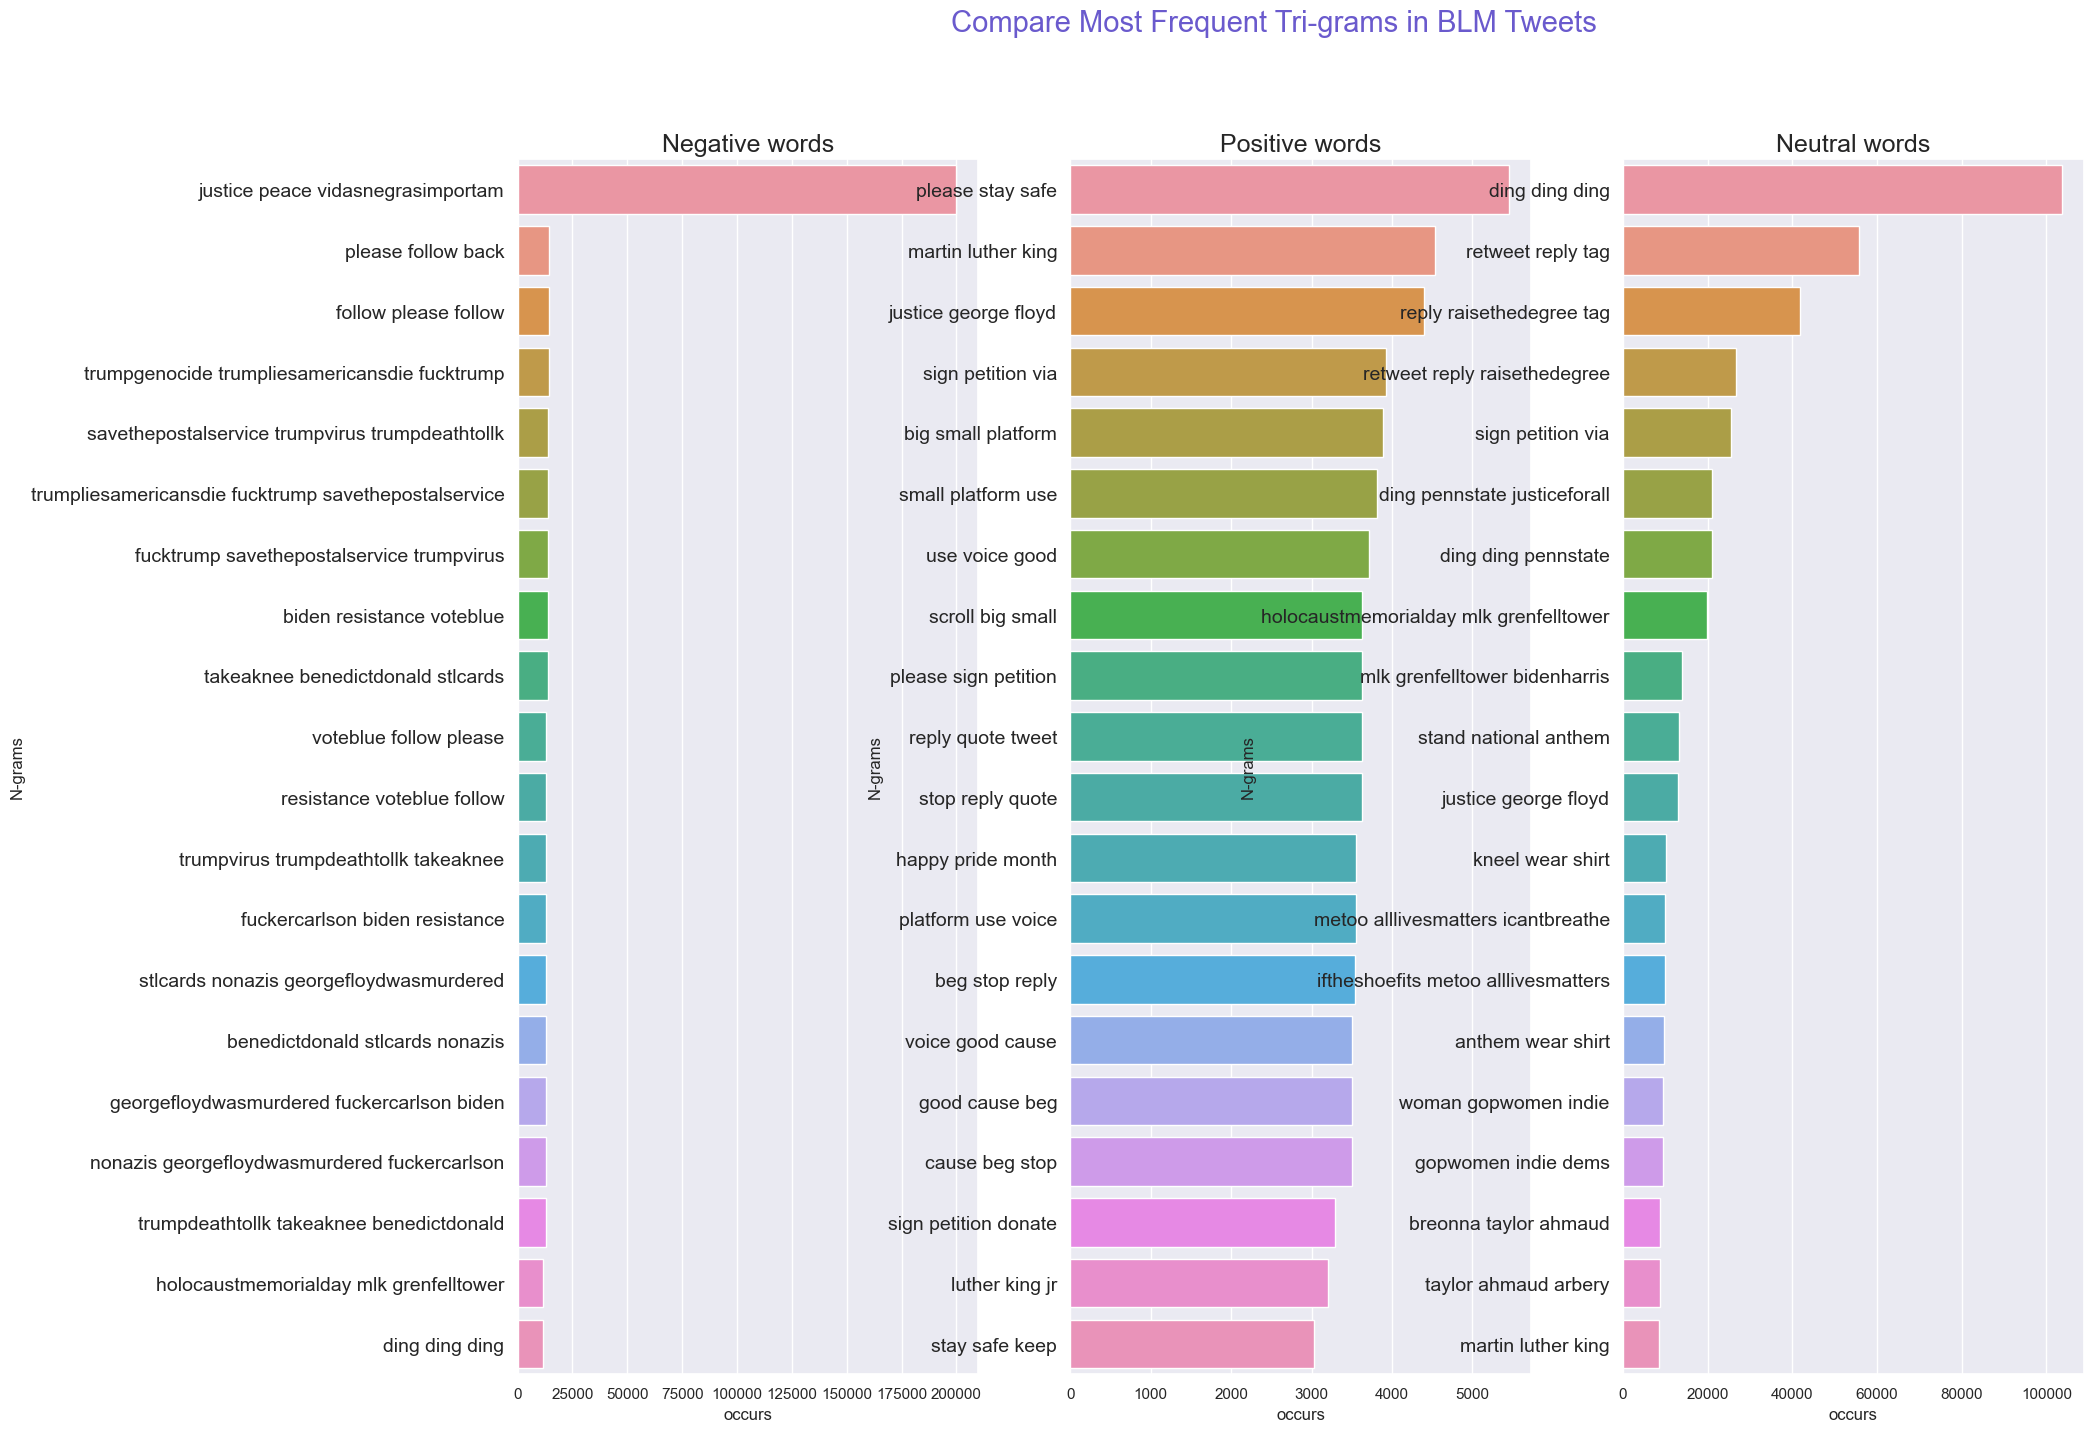

In [22]:
fig, axes = plt.subplots(1, 3)

fig.suptitle('Compare Most Frequent Tri-grams in BLM Tweets',
             size=21, color='SlateBlue')
axes[0].set_title('Negative words', size=18)
axes[1].set_title('Positive words', size=18)
axes[2].set_title('Neutral words', size=18)

plot_ngrams(ngrams_fn(df_copy, target_label='negative', n_grams=3), axes=axes[0])
plot_ngrams(ngrams_fn(df_copy, target_label='positive', n_grams=3), axes=axes[1])
plot_ngrams(ngrams_fn(df_copy, target_label='neutral', n_grams=3), axes=axes[2])
plt.show()

In [64]:
ngrams_fn(df_copy, target_label='positive', n_grams=3).reset_index(drop=True)\
.head(50).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,strongertogether follow resister,9286
1,please stay safe,6003
2,martin luther king,4585
3,please sign petition,4154
4,sign petition via,3931
5,big small platform,3892
6,small platform use,3813
7,happy pride month,3772
8,use voice good,3724
9,scroll big small,3633


In [65]:
ngrams_fn(df_copy, target_label='negative', n_grams=3).reset_index(drop=True)\
.head(50).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,please follow back,14273
1,follow please follow,14271
2,trumpgenocide trumpliesamericansdie fucktrump,14183
3,trumpliesamericansdie fucktrump savethepostalservice,14061
4,savethepostalservice trumpvirus trumpdeathtollk,14061
5,fucktrump savethepostalservice trumpvirus,14061
6,biden resistance voteblue,14060
7,takeaknee benedictdonald stlcards,13899
8,voteblue follow please,12824
9,resistance voteblue follow,12824


In [66]:
ngrams_fn(df_copy, target_label='neutral', n_grams=3).reset_index(drop=True)\
.head(50).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,ding ding ding,103632
1,retweet reply tag,56197
2,reply raisethedegree tag,41825
3,retweet reply raisethedegree,26603
4,sign petition via,25827
5,ding pennstate justiceforall,22718
6,ding ding pennstate,21025
7,holocaustmemorialday mlk grenfelltower,19728
8,mlk grenfelltower bidenharris,13954
9,stand national anthem,13125


In [23]:
def n_grams(text, n_gram=2):
    text = text.casefold().split()
    return list(map(' '.join, zip(*[text[i:] for i in range(n_gram)])))

In [68]:
def n_gram_interpretation(n_gram):
    """
    | Created function for interpreting the `n_gram` from integer to its definition.
    Args:
        n_gram (int): number of words per sentence
    Returns:
        Text
    """
    n_gram_dict = defaultdict(lambda: 'N-grams',
                              {1: 'Uni-gram',
                               2: 'Bi-grams',
                               3: 'Tri-grams'})
    return n_gram_dict[n_gram]

In [69]:
def apply_n_gram_fn(dataframe,
                    n_gram=2):
    # initialize default dict with type `set` to remove duplicates indexes
    dicto = defaultdict(set)
    for index, tweet in dataframe['text_without_stopwords_freq'].items():
        for context in n_grams(tweet, n_gram):
            dicto[context].add(index)

    # sort the dict descending form
    dicto = {key: value for key, value in sorted(dicto.items(), key=lambda x: len(x[1]))[::-1]}
    # Convert the dict to list of tuples and 
    # switch keys & values to map it with the main dataframe
    dicto = [(value,key) for key in dicto for value in dicto[key]]
    df = pd.DataFrame(dicto)
    # Choose the most frequent N-gram and slice it from the synthetic dataframe
    df = df[~df.iloc[:,0].duplicated(keep='first')]
    # Concatenate both (Synthetic df & the original df) by indexes
    merged_df = dataframe.merge(df.iloc[:,1], how='left',
                                left_on=dataframe.index.values,
                                right_on=df.iloc[:,0])
    # Drop the key index and keep the rest
    merged_df.drop(columns='key_0', inplace=True)
    # Dealing with NaN values: 
    merged_df.fillna('IGNORE TEXT', inplace=True)
    # Rename Column
    merged_df.rename(columns={merged_df.columns[-1]:n_gram_interpretation(n_gram)}, inplace=True)
    return merged_df

In [70]:
df_copy = apply_n_gram_fn(df_copy, 1)

In [71]:
df_copy = apply_n_gram_fn(df_copy, 2)

In [72]:
df_copy = apply_n_gram_fn(df_copy, 3)

In [73]:
df_copy.to_parquet(r"C:\Users\fashaikh\Desktop\Thesis_main\ngrams.parquet")

In [74]:
bi_grams = df_copy['Bi-grams'].value_counts()

In [75]:
bi_grams

IGNORE TEXT                       448579
peace vidasnegrasimportam         203464
george floyd                      190843
police brutality                  129548
white supremacist                 108864
                                   ...  
right bet                              1
justiceprevails letfreedomring         1
justiceforvon veteran                  1
cet homme                              1
oh certainly                           1
Name: Bi-grams, Length: 411031, dtype: int64

In [76]:
df_copy.head()

,cleanedContent,label,emotion_label,category,text,text_without_stopwords,text_lemmatized,text_without_stopwords_freq,Uni-gram,Bi-grams,Tri-grams
0,Everyday that the killers of #AhmaudArbery rem...,negative,fear,African American South,everyday that the killers of ahmaudarbery rema...,everyday killers ahmaudarbery remain free anot...,everyday killer ahmaudarbery remain free anoth...,everyday killer ahmaudarbery remain free anoth...,white,another day,traumatic stress disorder
1,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,day arrest gregorymcmichael travismcmichael mu...,protest,day arrest,kkk still run
2,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,day arrest gregorymcmichael travismcmichael mu...,protest,day arrest,kkk still run
3,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,day arrest gregorymcmichael travismcmichael mu...,protest,day arrest,kkk still run
4,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,day arrest gregorymcmichael travismcmichael mu...,protest,day arrest,kkk still run


In [77]:
tri_grams = df_copy['Tri-grams'].value_counts()

In [78]:
df_bi = df_copy[df_copy['Bi-grams'] == 'IGNORE TEXT']

In [2]:
df = pd.read_parquet(r"C:\Users\fashaikh\Desktop\Thesis_main\ngrams.parquet")

In [3]:
df.head()

,cleanedContent,label,emotion_label,category,text,text_without_stopwords,text_lemmatized,text_without_stopwords_freq,Uni-gram,Bi-grams,Tri-grams
0,Everyday that the killers of #AhmaudArbery rem...,negative,fear,African American South,everyday that the killers of ahmaudarbery rema...,everyday killers ahmaudarbery remain free anot...,everyday killer ahmaudarbery remain free anoth...,everyday killer ahmaudarbery remain free anoth...,white,another day,traumatic stress disorder
1,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,day arrest gregorymcmichael travismcmichael mu...,protest,day arrest,kkk still run
2,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,day arrest gregorymcmichael travismcmichael mu...,protest,day arrest,kkk still run
3,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,day arrest gregorymcmichael travismcmichael mu...,protest,day arrest,kkk still run
4,It took 59 days for the @user to arrest #Grego...,negative,disgust,African American South,it took days for the to arrest gregorymcmichae...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,day arrest gregorymcmichael travismcmichael mu...,protest,day arrest,kkk still run


In [6]:
df['Tri-grams'].value_counts()

IGNORE TEXT                               1245014
retweet reply tag                           56661
reply raisethedegree tag                    41938
holocaustmemorialday mlk grenfelltower      33246
sign petition via                           32590
                                           ...   
continuously disrespect woman                   1
affirm god image                                1
care animal care                                1
marxist though right                            1
whats happen many                               1
Name: Tri-grams, Length: 1777832, dtype: int64

In [7]:
df[df['Bi-grams'] == 'ding ding']

,cleanedContent,label,emotion_label,category,text,text_without_stopwords,text_lemmatized,text_without_stopwords_freq,Uni-gram,Bi-grams,Tri-grams
577869,"Ding, ding, ding. Here we go for rd 4 - #Georg...",negative,disgust,Big Cities,ding ding ding here we go for rd georgefloydmu...,ding ding ding go rd georgefloydmurder blackli...,ding ding ding go rd georgefloydmurder blackli...,ding ding ding rd georgefloydmurder alllivesma...,protest,ding ding,ding ding ding
768105,Ding ding ding. Fuck all that exceptionalism. ...,positive,anger,Big Cities,ding ding ding fuck all that exceptionalism we...,ding ding ding fuck exceptionalism together bl...,ding ding ding fuck exceptionalism together bl...,ding ding ding fuck exceptionalism together,white,ding ding,ding ding ding
927475,Ding Ding Ding Its like they don't handle crit...,negative,anger,Big Cities,ding ding ding its like they do not handle cri...,ding ding ding like handle criticism well prov...,ding ding ding like handle criticism well prov...,ding ding ding handle criticism well prove cri...,protest,ding ding,ding ding ding
1385203,Ding ding ding!! 👀 It's time for a new trailer...,positive,joy,Big Cities,ding ding ding it time for a new trailer trail...,ding ding ding time new trailer trailer videog...,ding ding ding time new trailer trailer videog...,ding ding ding new trailer trailer videogame i...,protest,ding ding,ding ding ding
1385205,Ding ding ding!! 👀 It's time for a new trailer...,positive,joy,Big Cities,ding ding ding it time for a new trailer trail...,ding ding ding time new trailer trailer videog...,ding ding ding time new trailer trailer videog...,ding ding ding new trailer trailer videogame i...,protest,ding ding,ding ding ding
...,...,...,...,...,...,...,...,...,...,...,...
16533318,@user Hello! Deblasio! Ding ding ding! Your fa...,negative,anger,Rural Middle America,hello deblasio ding ding ding your faithful ta...,hello deblasio ding ding ding faithful taxpaye...,hello deblasio ding ding ding faithful taxpaye...,hello deblasio ding ding ding faithful taxpaye...,protest,ding ding,ding ding ding
16533319,@user Hello! Deblasio! Ding ding ding! Your fa...,negative,anger,Rural Middle America,hello deblasio ding ding ding your faithful ta...,hello deblasio ding ding ding faithful taxpaye...,hello deblasio ding ding ding faithful taxpaye...,hello deblasio ding ding ding faithful taxpaye...,protest,ding ding,ding ding ding
16533320,@user Hello! Deblasio! Ding ding ding! Your fa...,negative,anger,Rural Middle America,hello deblasio ding ding ding your faithful ta...,hello deblasio ding ding ding faithful taxpaye...,hello deblasio ding ding ding faithful taxpaye...,hello deblasio ding ding ding faithful taxpaye...,antifa,ding ding,ding ding ding
16793659,@user @user @user @user @user Oh it's on NOW!!...,positive,joy,Working Class Country,oh it is on now ding ding ding,oh ding ding ding,oh ding ding ding,oh ding ding ding,protest,ding ding,ding ding ding
